#### Clear Ram

In [1]:
import gc
gc.collect()

3

#### Load Libraries

In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

random.seed(444)


### Load & Process Data

#### Define Data Paths

In [2]:
main_path = '[path_to_datafolder]'
main_path_wavelet = '[path_to_datafolder]/scallogramTest/gaus1/'

ab_edf_path = main_path + 'edf/Abnormal EDF Files/'
n_edf_path = main_path + 'edf/Normal EDF Files/'
ab_labels_path = main_path + 'csv/SW & SSW CSV Files/'
save_path = main_path + 'ml_data/numpy_arrays/'

In [3]:
class_label_names = ['normal', 'slowing', 'spike and wave']

#### Load Data from File

In [4]:
all_edf_data = np.concatenate((os.listdir(n_edf_path),os.listdir(ab_edf_path)), axis = 0)
print(len(all_edf_data))

1075


In [5]:
# Line position for train and test

train_pos = 0
valid_pos = 393227
test_pos = 462620

In [6]:
w = pywt.Wavelet('db2')

In [ ]:
train_window_data = []
train_window_labels = []

test_window_data = []
test_window_labels = []

normal_count = 0
slowing_count = 0
spike_count = 0

for edf_name in tqdm(all_edf_data):
    file_num = int(edf_name[:-4])
    
    if edf_name in os.listdir(ab_edf_path):
        edf_path = ab_edf_path
    else:
        edf_path = n_edf_path
    
    raw = mne.io.read_raw_edf(edf_path+edf_name,preload = True,exclude = ['A1','A2'])     # Importing all EEG Channels, exculding A1 A2 since matlab has already refrenced the channels with A1 and A2
    raw.filter(l_freq=1,h_freq=45)      # Bandpass filtering [1-45] Hz
    epochs=mne.make_fixed_length_epochs(raw,duration=2,overlap=1)
    epochs_data=epochs.get_data()
    
    data = np.array(raw.get_data()[0:19])
    print('epochs_data shape = ',epochs_data.shape)
    
    # Epochs_data = np.concatenate((Epochs_data, epochs_data), axis=0)

    with open(main_path_wavelet + 'window_tracker.txt', 'r') as f:
        lines = f.readlines()
        for single_line in lines[train_pos+1:valid_pos]:
            single_line_list = single_line.split(' ')
            if edf_name == single_line_list[0]:
                
                data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                pca = PCA(n_components = 2)
                decomp_levels = pywt.wavedec(data, wavelet=w,level = 4)
                feature_vector = []
                for k in range(len(decomp_levels)):
                    feature_vector.append(stat_features(decomp_levels[k]))
                feature_vector = np.array(feature_vector)
                pca.fit(feature_vector)
                pca_features = pca.fit_transform(feature_vector)
                train_window_data.append(np.array(pca_features.flatten()))

                train_window_labels.append(np.array(int(single_line_list[3])))
        
        for single_line in lines[valid_pos+1:test_pos]:
            single_line_list = single_line.split(' ')
            if edf_name == single_line_list[0]:
                
                data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                pca = PCA(n_components = 2)
                decomp_levels = pywt.wavedec(data, wavelet=w,level = 4)
                feature_vector = []
                for k in range(len(decomp_levels)):
                    feature_vector.append(stat_features(decomp_levels[k]))
                feature_vector = np.array(feature_vector)
                pca.fit(feature_vector)
                pca_features = pca.fit_transform(feature_vector)
                train_window_data.append(np.array(pca_features.flatten()))

                train_window_labels.append(np.array(int(single_line_list[3])))
        
        for single_line in lines[test_pos+1:]:
            single_line_list = single_line.split(' ')
            if edf_name == single_line_list[0]:
                
                data = epochs_data[int(single_line_list[2])][int(single_line_list[1])]
                pca = PCA(n_components = 2)
                decomp_levels = pywt.wavedec(data, wavelet=w,level = 4)
                feature_vector = []
                for k in range(len(decomp_levels)):
                    feature_vector.append(stat_features(decomp_levels[k]))
                feature_vector = np.array(feature_vector)
                pca.fit(feature_vector)
                pca_features = pca.fit_transform(feature_vector)
                test_window_data.append(np.array(pca_features.flatten()))

                test_window_labels.append(np.array(int(single_line_list[3])))

    

In [8]:
# Save
np.save(save_path + 'X_train.npy', train_window_data)
np.save(save_path + 'X_test.npy', test_window_data)

np.save(save_path + 'y_train.npy', train_window_labels)
np.save(save_path + 'y_test.npy', test_window_labels)

In [9]:
gc.collect

<function gc.collect(generation=2)>

In [10]:
X_train = np.load(save_path + 'X_train.npy')
y_train = np.load(save_path + 'y_train.npy')

X_test = np.load(save_path + 'X_test.npy')
y_test = np.load(save_path + 'y_test.npy')

In [11]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(462616, 10)
(462616,)
(153350, 10)
(153350,)


#### Standardize Data

In [12]:
sc = StandardScaler()
mm_sc = MinMaxScaler()

In [13]:
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

mm_sc.fit(X_train)
X_train_mm_sc = mm_sc.transform(X_train)
X_test_mm_sc = mm_sc.transform(X_test)

### Model Implementation

#### Accuracy Metrics and Confusion Matrix

In [15]:
def plot_confusion_matrix(cm, classes = [0, 1, 2],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.rcParams['figure.dpi'] = 150

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
def print_score(clf, X_train, y_train, X_test, y_test, train = True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train), digits=5)))
        cm = confusion_matrix(y_train, clf.predict(X_train))
        plot_confusion_matrix(cm)
        
    elif train == False:
        '''
        test performance
        '''
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test), digits=5)))
        cm = confusion_matrix(y_test, clf.predict(X_test))
        plot_confusion_matrix(cm)

#### Model 1: Simple Decision Tree Classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
cart_clf = DecisionTreeClassifier(criterion='entropy',max_features = 'sqrt',random_state = 0,max_depth=5,min_samples_leaf=1,splitter = 'best')

In [19]:
cart_clf.fit(X_train_sc, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       random_state=0)

Test Result:

accuracy score: 0.6982

Classification Report: 
               precision    recall  f1-score   support

           0    0.86582   0.79295   0.82778     96579
           1    0.48981   0.59858   0.53876     36730
           2    0.42452   0.42393   0.42423     20041

    accuracy                        0.69817    153350
   macro avg    0.59338   0.60515   0.59692    153350
weighted avg    0.71809   0.69817   0.70582    153350


Confusion matrix, without normalization
[[76582 14838  5159]
 [ 8386 21986  6358]
 [ 3482  8063  8496]]


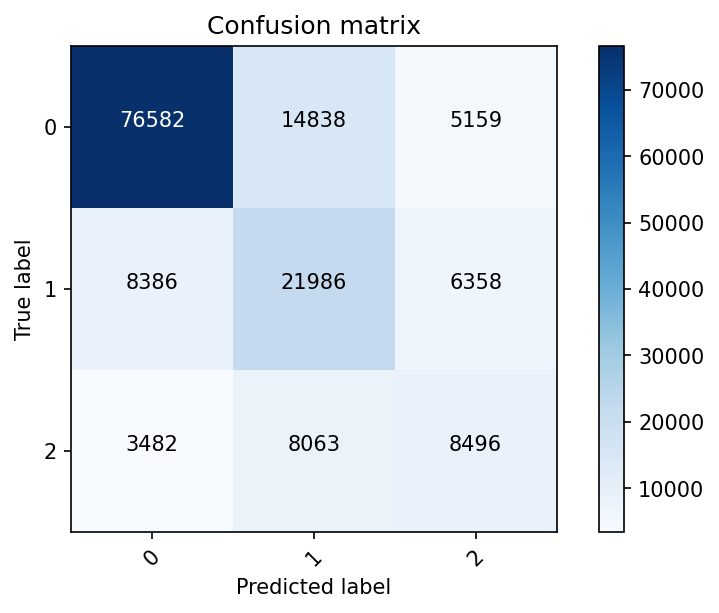

In [21]:
print_score(cart_clf, X_train_sc, y_train, X_test_sc, y_test, train = False)

#### Model 2: Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
rf_clf = RandomForestClassifier(n_estimators = 100,criterion='entropy',max_features = 'sqrt',random_state = 0,max_depth=7,min_samples_leaf=2)
rf_clf.fit(X_train_sc, y_train.ravel())

RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2,
                       random_state=0)

Test Result:

accuracy score: 0.7273

Classification Report: 
               precision    recall  f1-score   support

           0    0.86783   0.83603   0.85163     96579
           1    0.57171   0.53809   0.55439     36730
           2    0.42840   0.55022   0.48173     20041

    accuracy                        0.72732    153350
   macro avg    0.62265   0.64145   0.62925    153350
weighted avg    0.73948   0.72732   0.73210    153350


Confusion matrix, without normalization
[[80743  8883  6953]
 [ 9206 19764  7760]
 [ 3091  5923 11027]]


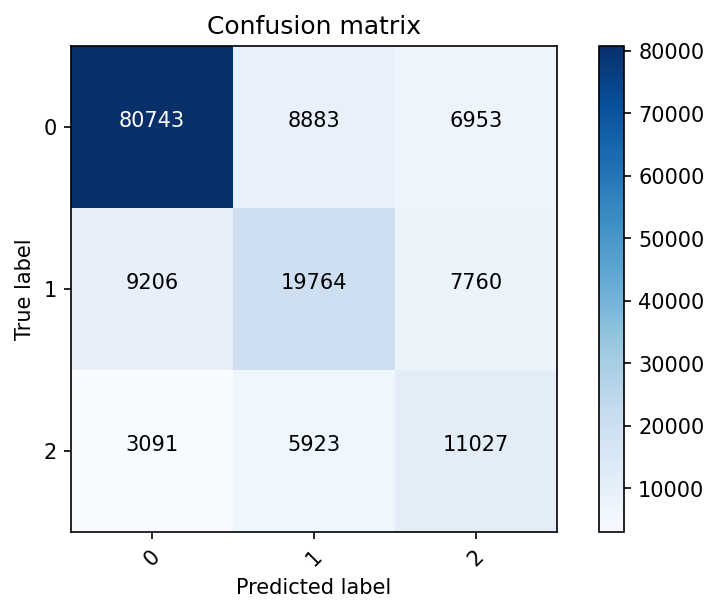

In [25]:
print_score(rf_clf, X_train_sc, y_train, X_test_sc, y_test, train = False)                                     

#### Model 3: Linear SVM

In [26]:
from sklearn import svm

In [27]:
svm_clf = svm.SVC(kernel='linear',decision_function_shape = 'ovr',gamma='auto',random_state=0, C = 2.0,verbose=True)
svm_clf.fit(X_train_mm_sc, y_train)

[LibSVM]

........................................................................................................
*....
*.
*.
*.
*
optimization finished, #iter = 110765
obj = -348734.515954, rho = 7.627503
nSV = 175399, nBSV = 175379
...................................................................................
*....
*.
*
optimization finished, #iter = 88000
obj = -282473.271020, rho = 0.307886
nSV = 141401, nBSV = 141381
.......................................................................................
*.
*......
*...
*.
*.
*.
*
optimization finished, #iter = 97816
obj = -298345.918313, rho = -9.813318
nSV = 151806, nBSV = 151783
Total nSV = 296939


SVC(C=2.0, gamma='auto', kernel='linear', random_state=0, verbose=True)

Test Result:

accuracy score: 0.7117

Classification Report: 
               precision    recall  f1-score   support

           0    0.78482   0.89546   0.83650     96579
           1    0.54605   0.35837   0.43274     36730
           2    0.49856   0.47388   0.48590     20041

    accuracy                        0.71172    153350
   macro avg    0.60981   0.57590   0.58505    153350
weighted avg    0.69022   0.71172   0.69397    153350


Confusion matrix, without normalization
[[86483  5996  4100]
 [18115 13163  5452]
 [ 5597  4947  9497]]


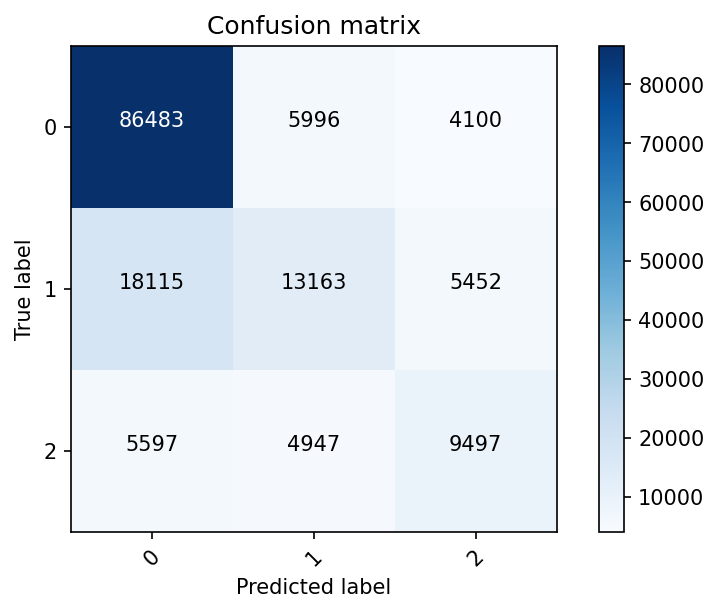

In [28]:
print_score(svm_clf, X_train_mm_sc, y_train, X_test_mm_sc, y_test, train = False)

END